# Joint project AMD + SMML

https://docs.google.com/document/d/1oqoIyRUI_digfIokf53fox0I1eWiTFzQaae-PxMre0Y/edit

The project is based on the analysis of the «2013 American Community Survey» dataset published on Kaggle and released under the public domain license (CC0).

https://www.kaggle.com/census/2013-american-community-survey

The task is to implement from scratch a learning algorithm for **regression** with **square loss** (e.g., **ridge regression**). The label to be predicted must be selected among the following 5 attributes, removing the remaining 4 from the dataset:
- PERNP (Person's earnings)
- PINCP (Person's income)
- WAGP (Wages or salary income past 12 months)
- HINCP (Household income)
- FINCP (Family income)

**Important**: the techniques used in order to infer the predictor should be time and space efficient, and scale up to larger datasets.


In [1]:
import os, zipfile, json, math, progressbar, pytz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import when, count, col
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler, Imputer, PCA
from pyspark.ml.stat import Summarizer, Correlation
from pyspark.mllib.regression import LabeledPoint
%matplotlib inline

In [2]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

## Dataset download and prerocessing

Below, there are functions used in order to download and preprocess the dataset. Some functions used to visualize some information about the data are commented, because they are not necessary for the project to work properly and they slow up the computation.

In [3]:
def download_dataset():
    """
    Checks if the dataset has already been downloaded and, if not, downloads and unzips it.
    """
    
    if (os.path.exists('./data/2013-american-community-survey/ss13husa.csv') and
        os.path.exists('./data/2013-american-community-survey/ss13husb.csv') and 
        os.path.exists('./data/2013-american-community-survey/ss13pusa.csv') and
        os.path.exists('./data/2013-american-community-survey/ss13pusb.csv')):
        print('Data already downloaded.')
        return
    
    print('Downloading the dataset...')
    os.system('mkdir ./data')
    os.system('kaggle datasets download census/2013-american-community-survey -p ./data')

    print('Unzipping the dataset...')
    with zipfile.ZipFile("./data/2013-american-community-survey.zip","r") as zip_ref:
        zip_ref.extractall("./data/2013-american-community-survey")

    print('DONE! Data have been extracted in dir {}.'.format("./data/2013-american-community-survey"))

def plot_na_distribution(null_df):
    """
    Plots the distribution of missing values in features in the training set.
    
    Args:
        nul_df (PySpark DataFrame): DataFrame containing the fraction of missing values for each feature.
    """
    
    null_dict = null_df.take(1)[0].asDict()
    null_distr = [null_dict[k] for k in null_dict.keys()]
    
    sns.set_style("white")
    
    plt.figure(num = None, figsize = (12, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')
    g = sns.histplot(null_distr, bins = 40, color = "r")
    plt.suptitle('Distribution of missing values in training set', fontsize = 20)
    plt.xlabel("Fraction of missing values", fontsize = 14)
    plt.ylabel("Number of features", fontsize = 14)
    #plt.savefig('images/na_distr.png')
    
def plot_outliers_evolution(columns, sizes):
    """
    Plots the figure containing the progression of the size of the training set as we gradually remove outliers
        for each feature.

    Args:
        columns (list od strings): List containing the names of the features
        sizes (list of ints): List containing the number of elements in the training set after every feature
            is analyzed.
    """
    sns.set_style("white")
    
    fig = plt.figure(figsize = (12, 7))
    g = sns.lineplot(x = columns, y = sizes, color = 'crimson')
    g.set_xticklabels(labels = columns, rotation=90)
    
    fig.suptitle('Evolution of training test size', fontsize = 20)
    plt.xlabel('Feature', fontsize = 14)
    plt.ylabel('Training set size', fontsize = 14)
    
    new_ticks = [i.get_text() for i in g.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), 5), new_ticks[::5])
    
    plt.show()
    #plt.savefig('images/outliers.png')
    
def remove_outliers(train_df, test_df, val_df, features_to_filter):
    """
    Finds and removes the outliers from the training, test and validation set for the specified features.
        
    Note:
        If the list of features to filter is huge, this operation can be slow and the resulting DataFrames
            can contains a small portion of the original data. Be careful in chosing the feature list.

    Args:
        train_df (PySpark DataFrame): Training set.
        test_df (PySpark DataFrame): Test set.
        val_df (PySpark DataFrame): Validation set.
        features_to_filter (list of strings): List of features' names for which we want to remove the outliers.

    Returns:
        PySpark DataFrame: Training set without the outliers.
        PySpark DataFrame: Test set without the outliers.
        PySpark DataFrame: Validation set without the outliers.
    """  
    
    print("Dropping outliers...")
    # Uncomment the commented lines in order to plot the evolution of the training set size. This is done only
    # for evaluation purpose and slows up the execution.
    #train_sizes = []
    
    for i in range(len(features_to_filter)):        
        quantiles = train_df.approxQuantile(features_to_filter[i], [0.25, 0.75], 0.1)
        iqr = quantiles[1] - quantiles[0]
        #c = train_df.count()
        
        # If iqr is 0, it means that all the data points assume the same value for this feature.
        if iqr != 0:                    
            train_df = train_df.filter(col(features_to_filter[i]).between(quantiles[0] - (1.5 * iqr),
                                                                        quantiles[1] + (1.5 * iqr)))
            test_df = test_df.filter(col(features_to_filter[i]).between(quantiles[0] - (1.5 * iqr),
                                                                        quantiles[1] + (1.5 * iqr)))
            val_df = val_df.filter(col(features_to_filter[i]).between(quantiles[0] - (1.5 * iqr),
                                                                        quantiles[1] + (1.5 * iqr)))          
            #c = train_df.count()
        
        #train_sizes.append(c)
        
    print("DONE OUTLIERS REMOVING")

    #plot_outliers_evolution(features_to_filter, train_sizes)
    
    return train_df, test_df, val_df

def raw_label_stats(transformed_train_df, label):
    """
    Computes some stats on the raw label data, such as the minimum and the maximum values, the mean and the
        standard deviation, in order to revert the scaling process.
        
    Args:
        transformed_train_df (PySpark DataFrame): DataFrame containing a single column of features vectors
            belonging to the training points.
        label (string): Name of the feature to be predicted.
        
    Returns:
        Dictionary: Dictionary containng the minimum, the maximum, the mean and the standard deviation of the
            label raw values.
    """
    
    # We should save max and min label (if we use MinMaxScaler).
    # We should save mean and standard deviation (if we use StandardSacaler).
    stats_df = transformed_train_df.select(Summarizer.metrics("min", "max", "mean", "variance")
                                       .summary(transformed_train_df['label']))
    stats = stats_df.take(1)[0]
    
    label_stats = dict()
    label_stats["min"] = stats[0][0][0]
    label_stats["max"] = stats[0][1][0]
    label_stats["mean"] = stats[0][2][0]
    label_stats["std"] = math.sqrt(stats[0][3][0])
    
    print("{} stats:".format(label))
    print(label_stats)
    
    return label_stats
    
def plot_corr_matrix(corr_matrix, scheme):
    """
    Plots the correlation matrix between the features in training set.
    
    Args:
        corr_matrix (list of lists of floats): matrix containing the values of the correlation for each
            coupple of attributes.
        scheme (list of strings): list containing the names of the features.
    """
    
    corr_df = pd.DataFrame(corr_matrix)
    corr_df.columns = scheme
    d = dict()
    for i in range(len(scheme)):
        d[i] = scheme[i]

    corr_df.rename(d, inplace = True)

    sns.set(rc = {'figure.figsize':(15,13)})
    sns_plot = sns.heatmap(corr_df, cmap = "RdBu_r")
    #sns_plot.savefig("images/corr_matrix.png")
    
def parse_point(row, intercept = True):
    """
    Converts a row of a pyspark dataframe into a LabeledPoint.
    
    Args:
        row (PySpark DataFrame row): Row of a DataFrame composed by an array of features, an array containing
            the label, an array of scaled features, an array containing the scaled label and an array
            containing the values found by PCA and a double corresponding to the value to be predicted.
        intercept (boolean): If True, a feature with a constant value 1 is added in order to learn also
            the value of the intercept. Default value is True.

    Returns:
        LabeledPoint: The line is converted into a LabeledPoint, which consists of a label and
            features.
    """
    
    row_dict = row.asDict()
    label_value = np.array(row_dict['scaledLabel'])[0]
    feature_list = np.array(row_dict['pcaFeatures']).tolist()
    
    if intercept: feature_list.insert(0, 1.0)
    
    return LabeledPoint(label_value, feature_list)
    
def preprocess(train_df, test_df, val_df, na_threshold, label, n_features, data_type, imputer_strategy = 'mean'):
    """
    Preprocess a PySpark DataFrame, dropping the categorical feature and the discarded labels,
        casting the remaining features in double, dealing with null values with imputation and 
        dropping the features with too many missing values, dropping also all the data points
        with missing label. Optionally, scales all the features of the DataFrame.
        
    Note:
        Feature scaling can slow up the process if the DataFrame is huge.

    Args:
        train_df (PySpark DataFrame): Portion of the DataFrame read by the csv file, corresponding to the
            training set.
        test_df (PySpark DataFrame): Portion of the DataFrame read by the csv file, corresponding to the test
            set.
        val_df (PySpark DataFrame): Portion of the DataFrame read by the csv file, corresponding to the
            validation set.
        na_threshold (float between 0 and 1): Threshold that establish if a feature should be dropped or not
            based on its percentage of null values.
        label (string): Feature that corresponds to the chosen label to be predicted.
        n_features (int): Number of features we want to obtain after we apply the PCA dimensionality reduction
            strategy.
        data_type (string): It can be `p` if the label to be predicted belongs to the person dataset, or `h`
            if the label belongs to the household dataset.
        imputer_strategy (string): It can be `mean` or `median`, based on the imputation strategy we choose.
            Default value is `mean`.

    Returns:
        PySpark DataFrame: Restult of the processing of the original DataFrame.
    """    
    
    print("Dropping features...")
    train_df = train_df.drop('RT')
    test_df = test_df.drop('RT')
    val_df = val_df.drop('RT')
    
    possible_labels = ['PERNP', 'PINCP', 'WAGP'] if data_type == 'p' else ['HINCP', 'FINCP']  
    possible_labels.remove(label)
    
    for i in possible_labels:
        train_df = train_df.drop(i)
        test_df = test_df.drop(i)
        val_df = val_df.drop(i)

    print("Casting features to float...")    
    train_df = train_df.select([col(c).cast("float") for c in train_df.columns])
    test_df = test_df.select([col(c).cast("float") for c in test_df.columns])
    val_df = val_df.select([col(c).cast("float") for c in val_df.columns])
    
    print('Dropping data points with null label...')
    train_df = train_df.filter(train_df[label].isNotNull()) 
    test_df = test_df.filter(test_df[label].isNotNull())
    val_df = val_df.filter(val_df[label].isNotNull())
        
    print("Dropping features with more than {}% null values...".format(int(na_threshold * 100)))
    n = train_df.count()
    null_df = train_df.select([(count(when(col(c).isNull(), c))/n).alias(c) for c in train_df.columns])
    
    # Uncomment the following line to plot the distribution of null values in training features.
    #plot_na_distribution(null_df)
    
    scheme = train_df.columns
    null_distr = null_df.take(1)[0].asDict().values()
    
    for i in np.where(np.array(list(null_distr)) > na_threshold)[0]:
        train_df = train_df.drop(scheme[i])
        test_df = test_df.drop(scheme[i])
        val_df = val_df.drop(scheme[i])
        
    print('We reduced the number of features to {}.'.format(len(train_df.columns)))  

    print('Imputing missing values...')    
    imputer = Imputer()
    imputer.setInputCols(train_df.columns)
    imputer.setOutputCols(train_df.columns)
    imputer.setStrategy(imputer_strategy)

    imputer = imputer.fit(train_df)
    
    train_df = imputer.transform(train_df)
    test_df = imputer.transform(test_df)
    val_df = imputer.transform(val_df)
    
    # Uncomment the following lines to filter out data points with outlier values for the specified features.
    # BE CAREFUL! If a lot of features are considered, a lot of data points will be removed from the dataset.
    # And the operation will take a lot of time
    #features_to_filter = [label]
    #train_df, test_df, val_df = remove_outliers(train_df, test_df, val_df, features_to_filter)
    
    scheme = train_df.columns
    scheme.remove(label)
    
    assembler = VectorAssembler(inputCols = scheme, outputCol = 'features')
    transformed_train_df = assembler.transform(train_df).select(['features', label])
    transformed_test_df = assembler.transform(test_df).select(['features', label])
    transformed_val_df = assembler.transform(val_df).select(['features', label])

    # Uncomment the following lines to compute the correlation matrix.
    # (Only for explorative task, the correlation will be handled with PCA)
    #print("Finding features with high correlation...")
    #matrix = Correlation.corr(transformed_train_df, "features").collect()[0][0]
    #corr_matrix = matrix.toArray().tolist()
    #plot_corr_matrix(corr_matrix, scheme)
    
    # Uncomment the following lines to print the coupples of attributes with high positive or negative correlation
    #print("Highly positive correlated features:")
    #positive_corr = [[print(scheme[i], scheme[j], corr_matrix[j][i]) for j in range(len(corr_matrix[i])) 
    #                  if i != j and corr_matrix[j][i] > .9] for i in range(len(corr_matrix))]
    #print("Highly negative correlated features:")
    #negative_corr = [[print(scheme[i], scheme[j], corr_matrix[j][i]) for j in range(len(corr_matrix[i])) 
    #                  if i != j and corr_matrix[j][i] < -.9] for i in range(len(corr_matrix))]
    
    assembler_lbl = VectorAssembler(inputCols = [label], outputCol = 'label')
    transformed_train_df = assembler_lbl.transform(transformed_train_df).select(['features', 'label'])
    transformed_test_df = assembler_lbl.transform(transformed_test_df).select(['features', 'label'])
    transformed_val_df = assembler_lbl.transform(transformed_val_df).select(['features', 'label'])
    
    label_stats = raw_label_stats(transformed_train_df, label)
    
    print("Feature scaling...")
    # Comment the StandardScaler line and uncomment the MinMixScaler line in order to normalize features between
    # 0 and 1.
    scaler = StandardScaler(inputCol = 'features', withMean = True, outputCol = 'scaledFeatures') \
                                                                        .fit(transformed_train_df)
    #scaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaledFeatures').fit(transformed_train_df)
    transformed_train_df = scaler.transform(transformed_train_df)
    transformed_test_df = scaler.transform(transformed_test_df)
    transformed_val_df = scaler.transform(transformed_val_df)
    
    scaler_lbl = StandardScaler(inputCol = 'label', withMean = True, outputCol = 'scaledLabel') \
                                                                        .fit(transformed_train_df)
    #scaler_lbl = MinMaxScaler(inputCol = 'label', outputCol = 'scaledLabel').fit(transformed_train_df)
    transformed_train_df = scaler_lbl.transform(transformed_train_df)
    transformed_test_df = scaler_lbl.transform(transformed_test_df)
    transformed_val_df = scaler_lbl.transform(transformed_val_df)
    
    print('Applying PCA for dimensionality reduction...')
    pca = PCA(k = n_features, inputCol = 'scaledFeatures', outputCol = 'pcaFeatures').fit(transformed_train_df)
    transformed_train_df = pca.transform(transformed_train_df)
    transformed_test_df = pca.transform(transformed_test_df)
    transformed_val_df = pca.transform(transformed_val_df)
    print('Explained Variance Ratio\n', pca.explainedVariance.toArray())
    
    print('Transforming each data point in a LabeledPoint...')
    parsed_train_data = transformed_train_df.rdd.map(lambda s: parse_point(s))
    parsed_test_data = transformed_test_df.rdd.map(lambda s: parse_point(s))
    parsed_val_data = transformed_val_df.rdd.map(lambda s: parse_point(s))

    print("DONE!")
        
    return parsed_train_data, parsed_test_data, parsed_val_data, label_stats

def save_preprocessed_rdd(rdd, filename):
    """
    Saves the rdd on disk as a file.
    
    Note:
        This operation can be really slow. It should be done once and only in case of multiple executions
            of the learning code, in order to avoid to recompute the preprocessing every time.
    
    Args:
        rdd (PySpark RDD): RDD that has to be saved on disk.
        filename (String): Name of the file to be saved.
    """
    
    print("Saving preprocessed data...")
    
    base_dir = os.path.join('./data')
    input_path = os.path.join(filename)
    file_name = os.path.join(base_dir, input_path)
    
    if (os.path.exists(filename)):
        print('File {} already exixsts. Unable to save the data.'.format(filename))
        return

    rdd.saveAsTextFile(file_name)

def parse_line(line):
    """
    Converts one line of a saved preprocessed data file in a LabledPoint.
    
    Args: 
        line (String): A line of the data file.
    
    Returns:
        LabeledPoint: LabeledPoint corresponding to the line in input.
    """
    
    label_value, feature_list = (line.strip()[1:-1]).split(',', 1)
    
    return LabeledPoint(float(label_value), [float(i) for i in feature_list[1:-1].split(',')])
    
def load_preprocessed_datasets():
    """
    Loads preprocessed data from disk.
    
    Returns:
        RDD of LabeledPoints: RDD containing the saved preprocessed training set.
        RDD of LabeledPoints: RDD containing the saved preprocessed test set.
        RDD of LabeledPoints: RDD containing the saved preprocessed validation set.
        Dictionary: Dictionary containing some statistics about the raw values of the label.
    """
    
    print('Reading the preprocessed saved dataset...')
    base_dir = os.path.join('./data')
    input_path_train = os.path.join('preprocessed_train_set')
    input_path_test = os.path.join('preprocessed_test_set')
    input_path_val = os.path.join('preprocessed_val_set')
    file_name_train = os.path.join(base_dir, input_path_train)
    file_name_test = os.path.join(base_dir, input_path_test)
    file_name_val = os.path.join(base_dir, input_path_val)

    parsed_train_data = sc.textFile("./data/preprocessed_train_set").map(lambda l: parse_line(l))
    parsed_test_data = sc.textFile("./data/preprocessed_test_set").map(lambda l: parse_line(l))
    parsed_val_data = sc.textFile("./data/preprocessed_val_set").map(lambda l: parse_line(l))
        
    label_stats = dict()
        
    with open('./data/label_stats.json', 'r') as f:
        label_stats = json.load(f)

    return parsed_train_data, parsed_test_data, parsed_val_data, label_stats
    
def get_datasets(sqlContext, label, n_features):
    """
    Loads preprocessed data from disk. If there are no already preprocessed data on disk, donwloads
        the dataset and preprocesses it.
        
    Args:
        sqlContext (PySpark SQLContext): PySpark SQL entry point, needed in order to create PySpark DataFrames.
        label (string): Name of the feature chosen as the label to be predicted.
        n_features (int): Number of features we want to obtain after the execution of the PCA algorithm for 
            dimensionality reduction.
        
    Returns:
        Returns:
        RDD of LabeledPoints: RDD containing the saved preprocessed training set.
        RDD of LabeledPoints: RDD containing the saved preprocessed test set.
        RDD of LabeledPoints: RDD containing the saved preprocessed validation set.
        Dictionary: Dictionary containing some statistics about the raw values of the label.
    """
    
    if (os.path.exists('./data/preprocessed_train_set') and
        os.path.exists('./data/preprocessed_train_set') and
        os.path.exists('./data/preprocessed_train_set')):
        return load_preprocessed_datasets()
    else:
        download_dataset() 
        
        data_type = 'p' if label in ['PERNP', 'PINCP', 'WAGP'] else 'h'
        
        print('Reading the dataset...')        
        base_dir = os.path.join('./data/2013-american-community-survey')
        input_path_a = os.path.join('ss13pusa.csv') if data_type == 'p' else os.path.join('ss13husa.csv')
        input_path_b = os.path.join('ss13pusb.csv') if data_type == 'p' else os.path.join('ss13husb.csv')
        file_name_a = os.path.join(base_dir, input_path_a)
        file_name_b = os.path.join(base_dir, input_path_b)

        df_a = sqlContext.read.csv(file_name_a, header = True)
        df_b = sqlContext.read.csv(file_name_b, header = True)

        df = df_a.union(df_b)
        
        n = df.count()
        header_list = df.columns
        print("Number of columns: {}\nNumber of rows: {}".format(len(header_list), n))
        
        print('Subdividing data into train, validation and test set...')
        weights = [.6, .2, .2]
        seed = 12345

        #df = df.sample(False, .0001)
        train_df, test_df, val_df = df.randomSplit(weights, seed = seed)
        
        na_threshold = .6
        print('Preprocessing with\n\tthreshold = {},\n\tlabel = {}\n...'.format(na_threshold, label))
        parsed_train_data, parsed_test_data, parsed_val_data, label_stats = preprocess(train_df, test_df,
                                                            val_df, na_threshold, label, n_features, data_type)
        
        # Change the following variable in True to save the preprocessed data
        # This has to be done in order to avoid re-preprocessing data in developing phase
        # BE CAREFUL! Saving data can take a lot of time
        save_preprocessed_data = False
        if save_preprocessed_data == True:
            save_preprocessed_rdd(parsed_train_data, "preprocessed_train_set")
            save_preprocessed_rdd(parsed_test_data, "preprocessed_test_set")
            save_preprocessed_rdd(parsed_val_data, "preprocessed_val_set")
            
            with open("./data/label_stats.json", "w") as f:
                json.dump(label_stats, f) 
            
        return parsed_train_data, parsed_test_data, parsed_val_data, label_stats
    
def real_label_minmax(scaled_lbl, lbl_stats, adjust_factor = True):
    """
    Converts a label scaled with the MinMaxScaler into a label in USD.

    Note:
        The variable ADJINC (Adjustment factor for income and earnings dollar amounts) is necessary to
            adjusts reported income to 2013 dollars.

    Args:
        scaled_lbl (float): MinMax scaled value for the feature choosen as label.
        lbl_stats (dictionary): Dictionary containing some stats relative to the raw values of the label
            such as the minimum and the maximum value.
        adjust_factor (boolean): if True, we apply the ADJINC factor to the value of the label. Default is
            True.

    Returns:
        float: Value for the choosen label measured in USD. It is obtained by reversing the
            normalization formula.
    """
    ADJINC = 1.007549 if adjust_factor == True else 1
    
    return round(((lbl_stats["max"] - lbl_stats["min"]) * scaled_lbl + lbl_stats["min"]) * ADJINC, 0)

def real_label_standard(scaled_lbl, lbl_stats, adjust_factor = True):
    """
    Converts a label scaled with the StandardScaler into a label in USD.
    
    Note:
        The variable ADJINC (Adjustment factor for income and earnings dollar amounts) is necessary to
            adjusts reported income to 2013 dollars.

    Args:
        scaled_lbl (float): Standard scaled value for the feature choosen as label.
        lbl_stats (dictionary): Dictionary containing some stats relative to the raw values of the label
            such as the mean and the standard deviation.
        adjust_factor (boolean): if True, we apply the ADJINC factor to the value of the label. Default is
            True.

    Returns:
        float: Value for the choosen label measured in USD. It is obtained by reversing the
            normalization formula.
    """
    ADJINC = 1.007549 if adjust_factor == True else 1
    
    return round((lbl_stats["std"] * scaled_lbl + lbl_stats["mean"]) * ADJINC, 0)

In [4]:
label = 'HINCP'
n_features = 30

parsed_train_data, parsed_test_data, parsed_val_data, label_stats = get_datasets(sqlContext, label, n_features)
parsed_train_data.cache()
parsed_test_data.cache()
parsed_val_data.cache()

Reading the preprocessed saved dataset...


PythonRDD[8] at RDD at PythonRDD.scala:53

### Data representation

The feature vector we obtain after applying PCA contains the features ordered by their variance in the map space. We can take the first PCA features and plot the data points in a two dimetional data space, colouring the points depending on the value of the label.

In [5]:
def plot_pca(parsed_train_data, sample, n_feat):
    """
    Plots the training set in function of the combination of the first specified number of PCA features.

    Args:
        parsed_train_data (RDD of LabeledPoints): preprocessed training set.
        sample (int): number of training point to show in the graph.
        n_feat (int): number of PCA features considered. Thus number should be low in order to have a
            readable plot. Otherwise, the execution time may be too high.
    """    
    sample_data = parsed_train_data.take(sample)
    
    sample_features = [np.array(s.features) for s in sample_data]
    sample_labels = [s.label for s in sample_data]
    
    sample_df = pd.DataFrame(sample_features)
    sample_df.columns = ['PC{}'.format(i) for i in range(len(sample_features[0]))]
    sample_df['HINCP (normalized)'] = sample_labels
    
    sns.set(font_scale = 1.6)
    sns.set_style("white")
    
    show_feat = ['PC{}'.format(i) for i in range(1, n_feat + 1)]
    show_feat.append('HINCP (normalized)')
    
    g = sns.PairGrid(sample_df[show_feat], hue = 'HINCP (normalized)', palette = "Spectral", height = 4, aspect = 1)
    g.map(sns.scatterplot)
    g.add_legend()
    #sns_plot.savefig("images/pca.png")

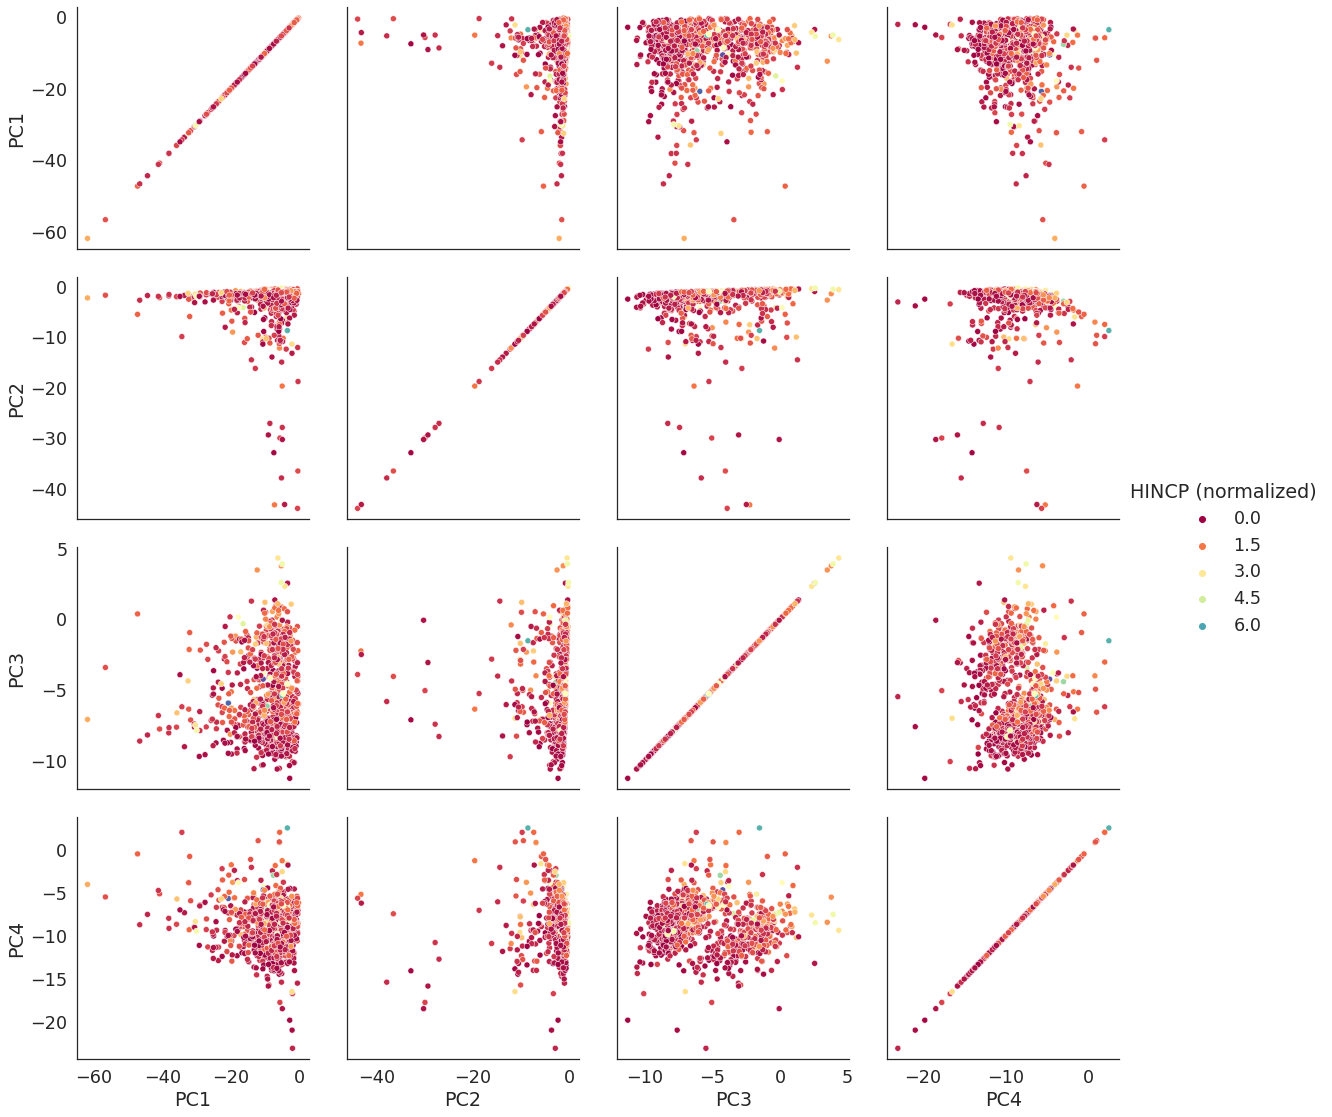

In [6]:
plot_pca(parsed_train_data, 1000, 4)

## Learning algorithm

Below there are the class of the ridge regression models and some utility functions. 

In [7]:
class RidgeRegression:
    """
    Implementation of the ridge regression algorithm that finds the minimum of the objective function
        via stochastic gradient descent. Since it considers a regression problem, the objective function
        to be minimized is the square loss.
    """
    
    def __init__(self, n_iters = 10, learn_rate = 0.1, reg_factor = 1e-10):
        """
        Constructor of a RidgeRegression object. Initializes it with its hyperparameters.

        Args:
            n_iters (int): Number of iterations for the stochastic gradient descent procedure.
            learn_rate (float): Initial learning rate for the stochastic grandient descent procedure.
            reg_factor (float): Regularization factor for the ridge regression.
        """
        
        self.n_iters = n_iters
        self.learn_rate = learn_rate 
        self.reg_factor = reg_factor
    
    def predict_with_label(self, observation, **kwargs):
        """
        Computes the predicted label and associates it with the real label.
        
        Args:
            observation (LabeledPoint): Data point composed by its feautures and its label.
            weigths (np array of double, optional): Array containig the weights of the linear relationship
                with the features of the data points. If not specified, weight vector of the model is
                used instead.
            
        Returns:
            tuple (float, float): Pair (true label, predicted label) relative to the given data point.
        """
        
        if len(kwargs.keys()) == 0:
            return (observation.label, self.weights.dot(DenseVector(observation.features)))
        else:
            return (observation.label, kwargs['weights'].dot(DenseVector(observation.features)))
    
    def _gradient_summand(self, weights, lp):
        """
        Computes a summand in the gradient formulation of the square loss.
        
        Args:
            weigths (DenseVector): Vector containing the weights learnt by the model.
            lp (LabeledPoint): A single observation composed by its features and its label.
            
        Returns:
            DenseVector: Dot product between the weights vector and the feature vector, minus the
                label and multiplied again for the the feature vector.
        """
        
        return (weights.dot(DenseVector(lp.features)) - lp.label) * lp.features
    
    def fit(self, train_data):
        """
        Trains the model in order to find the best weight vector that minimizes the square loss.
            It does so with stochastic gradient descent procedure.
            
        Args:
            train_data (RDD of LabeledPoints): training set used in order to real the weight vector.
            
        Returns:
            RidgeRegression: object corresponding to the lerant predictor.
        """
        
        n = train_data.count()
        d = len(train_data.take(1)[0].features)
        w = np.zeros(d)
        
        train_error = np.zeros(self.n_iters)

        bar = progressbar.ProgressBar(maxval = self.n_iters,
                                      widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()
        
        for i in range(self.n_iters):
            labels_and_preds_train = train_data.map(lambda p: self.predict_with_label(p, weights = w))
            train_error[i] = rmse(labels_and_preds_train)

            gradient_sum = train_data.map(lambda lp: DenseVector(self._gradient_summand(w, lp))) \
                            .reduce(lambda x, y: x + y)
            gradient = gradient_sum + (self.reg_factor * w)

            learn_rate_i = self.learn_rate / (n * np.sqrt(i + 1))
            w -= learn_rate_i * gradient
            
            bar.update(i + 1)
            
        bar.finish()

        self.weights = w
        self.train_error = train_error

        return self
    
    def predict(self, features):
        """
        Computes the predicted label for a given observation.
        
        Args:
            features (vector of floats): Feature vector of a data point.
            
        Returns:
            float: predicted label relative to the given data point.
        """
        
        return self.weights.dot(DenseVector(features))
    
    def write_on_file(self):
        """
        Writes the properties of the model on a JSON file in order to reload the model in consecutive
            executions.
        """
        if not os.path.exists('./models'):
            os.mkdir('./models')
            
        model = dict()
        model['n_iters'] = self.n_iters
        model['learn_rate'] = self.learn_rate
        model['reg_factor'] = self.reg_factor
        model['weights'] = self.weights.tolist()
        model['train_error'] = self.train_error.tolist()
        
        j = json.dumps(model, indent = 4)
        
        with open('./models/model_%d_%g_%g.json' % (self.n_iters, self.learn_rate, self.reg_factor), 'w') as f:
            print(j, file = f)

In [8]:
def squared_error(label, prediction):
    """
    Computes the squared error for a prediction.
        
    Args:
        label (float): True label for this observation.
        prediction (float): Predicted label for this observation.
            
    Returns:
        float: Squared difference between the true label and the predicted label.
    """
        
    return (label - prediction) ** 2

def rmse(labels_and_preds):
    """
    Computes the root mean squared error for an RDD of (true label, predicted label) tuples.
        
    Args:
       labels_and_preds (RDD of (float, float)): RDD of (true label, predicted label) tuples.
           
    Returns:
       float: Square root of the mean of the squared errors of all the tuples in the RDD.
    """
        
    return np.sqrt(labels_and_preds.map(lambda p: squared_error(*p)).mean())

def plot_train_error(model):
    """
    Saves the figure containing the progression of the training error for each iteration of the stochastic gradient
        descent procedure.

    Args:
        train_error (list of floats): List containing, for each iteration, the value of the training RMSE.
    """

    if not os.path.exists('./images'):
        os.mkdir('./images')
    
    fig = plt.figure(figsize = (12, 7))
    g = sns.lineplot(x = np.arange(model.n_iters), y = model.train_error, color = 'crimson')
    
    fig.suptitle('Evolution of training error through iterations', fontsize = 20)
    plt.xlabel('Iteration', fontsize = 14)
    plt.ylabel('Training error', fontsize = 14)
    plt.savefig('images/train_error_%d_%g_%g.png' % (model.n_iters, model.learn_rate, model.reg_factor))

def print_now():
    """
    Prints the current date and time.
    """
    
    tz = pytz.timezone('Europe/Rome')
    time = datetime.now(tz)
    print("Current time =", time.strftime("%d-%m-%y %H:%M:%S"))
    
def label_and_pred_usd(label_and_pred, label_stats):
    """
    Converts the real and the predicted label from standardized to usd.

    Args:
        label_and_pred (tuple of floats): Tuple containing the real standardized lable and the predicted 
            standardized label.
        label_stats (dictionary): Dictionary containing some statistics about the raw values of the label.
        
    Returns:
        tuple of floats: couple (real label in USD, predicted label in USD)
    """
    
    return (real_label_standard(label_and_pred[0], label_stats), real_label_standard(label_and_pred[1],
                                                                                     label_stats))

## Grid search

Let us now search for the best parameters combinatin. We have 3 different hyperparameters:

- Number of iterations: 500, 1000, 1500
- Regularization factor: 1, 1e-5, 1e-10
- Learning rate: 0.001, 0.0001, 1e-5 (from previous testing, we saw that learning rate = 0.01 gives numercial problems)

In [9]:
def plot_grid_search(n_iters_params, reg_factor_params, learn_rate_params, rmse_val_matrix):
    """
    Plots heatmaps showing the validation RMSE for each model trained in the grid search.

    Args:
        n_iters_params (list of int): list of parameters for the number of iterations of the stochastic
            gradient descent procedure.
        reg_factor_params (list of float): list of parameters for the regularization factor of ridge
            regression.
        learn_rate_params (list of float): list of parameters for the learning rate of the stochastic
            gradient descent procedure.
        rmse_val_matrix (numpy cubic matrix of floats): matrix containing the validation RMSE for each 
            combination of hyperparameters.
    """
    L = pd.Index(learn_rate_params, name = "λ")
    N = pd.Index(n_iters_params, name = "n")

    sns.set(font_scale = 1.4)
    fig, ax = plt.subplots(1, len(rmse_val_matrix))
    fig.set_figwidth(6 * len(rmse_val_matrix))
    fig.set_figheight(5)
    fig.tight_layout(pad = 3.0)
    
    for i in range(len(rmse_val_matrix)):
        rmse_df = pd.DataFrame(data = rmse_val_matrix[i], index = L, columns = N)
        
        sns.heatmap(rmse_df, cmap = "YlOrRd", linewidths = 2, annot = True, ax = ax[i], annot_kws = {"size": 14},
                fmt = '.5f')
        ax[i].set_title('ξ = {}'.format(reg_factor_params[i]))

def grid_search(train_set, val_set, n_iters_params, reg_factor_params, learn_rate_params):
    """
    Performs grid search in order to find the best hyperparameters.

    Args:
        train_set (RDD of LabeledPoints): Training set used to be used to train the model.
        val_set (RDD of LabeledPoints): Validation set used to be used to evaluate the model.
        n_iters_params (list of int): list of parameters for the number of iterations of the stochastic
            gradient descent procedure.
        reg_factor_params (list of float): list of parameters for the regularization factor of ridge
            regression.
        learn_rate_params (list of float): list of parameters for the learning rate of the stochastic
            gradient descent procedure.

    Returns:
        RidgeRegression: ridge regression model with the lowest rmse value on the validation set.
    """
    print('Performing grid search...')

    best_model = None
    best_rmse_val = float('inf')
    rmse_val_matrix = []

    for reg_factor in reg_factor_params:
        rmse_learn_rate = []
        
        for learn_rate in learn_rate_params:
            rmse_n_iters = []
            
            for n_iters in n_iters_params:                               
                print('Training the model with parameters:\n\tNumber of iterations: {}\n\tRegularization factor: {} \
                    \n\tLearning rate: {}'.format(n_iters, reg_factor, learn_rate))
                
                model = RidgeRegression(n_iters = n_iters, learn_rate = learn_rate, reg_factor = reg_factor)
                model.fit(parsed_train_data)
                # Uncomment the following line to write information about the trained model on file.
                #model.write_on_file()
                
                print('Training... DONE!')
                print('Training RMSE = {}'.format(model.train_error[-1]))

                # Evaluate the model on the validation set.
                labels_and_preds_val = parsed_val_data.map(lambda p: model.predict_with_label(p))
                rmse_val = rmse(labels_and_preds_val)

                print('Validation RMSE = {}'.format(rmse_val))
                rmse_n_iters.append(rmse_val)

                # Uncomment to print the evolution of the training error of the current model.
                #plot_train_error(model)

                if rmse_val < best_rmse_val:
                    best_model = model
                    best_rmse_val = rmse_val
                    
            rmse_learn_rate.append(rmse_n_iters)
            
        rmse_val_matrix.append(rmse_learn_rate)
     
    # Uncomment the following line to plot the gridsearch heatmap
    #plot_grid_search(n_iters_params, reg_factor_params, learn_rate_params, rmse_val_matrix)
    
    return best_model

**WARNING**: the execution of the following cell can be very time consuming. Ignore this cell and execute the next one to obtain directly the obect corresponding to the best model found within the grid search.

In [22]:
n_iters_params = [500, 1000, 1500]
reg_factor_params = [1, 1e-5, 1e-10]
learn_rate_params = [0.001, 1e-4, 1e-5]

print_now()
best_model = grid_search(parsed_train_data, parsed_val_data, n_iters_params, reg_factor_params, learn_rate_params)
print_now()

Current time = 28-09-20 13:20:15
Performing grid search...
Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1                     
	Learning rate: 0.001


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.8828257230639303
Validation RMSE = 0.8752631498716088
Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1                     
	Learning rate: 0.0001


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.9850455801468265
Validation RMSE = 0.976260280407189
Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1                     
	Learning rate: 1e-05


[========================================================================] 100%


Training... DONE!
Training RMSE = 1.0058116589351143
Validation RMSE = 0.9964179446059143
Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1e-05                     
	Learning rate: 0.001


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.8828257184213488
Validation RMSE = 0.8752631453038344
Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1e-05                     
	Learning rate: 0.0001


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.9850455800585022
Validation RMSE = 0.9762602803218448
Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1e-05                     
	Learning rate: 1e-05


[========================================================================] 100%


Training... DONE!
Training RMSE = 1.0058116589059327
Validation RMSE = 0.9964179445778993
Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1e-10                     
	Learning rate: 0.001


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.8828257184213028
Validation RMSE = 0.875263145303789
Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1e-10                     
	Learning rate: 0.0001


[========================================================================] 100%


Training... DONE!
Training RMSE = 0.9850455800585014
Validation RMSE = 0.976260280321844
Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1e-10                     
	Learning rate: 1e-05


[========================================================================] 100%


Training... DONE!
Training RMSE = 1.0058116589059323
Validation RMSE = 0.9964179445778989


NameError: name 'rmse_val_max' is not defined

## Evaluation of the best model

The best model corresponds to hyperparameters: 

- Number of iterations: 1500
- Regularization factor: 1e-10
- Learning rate: 0.001

The execution of the grid search takes a lot of time. In the following cell, we build the best model given the result of grid search, so that we do not need to re-execute the training every time.

In [10]:
best_model = RidgeRegression(n_iters = 1500, learn_rate = .001, reg_factor = 1e-10)
best_model.weights = np.array([0.0005034326091532248, 0.004261314388130753, 0.008611322028384476,
        0.056035500884573076, 0.03782015087636897, 0.01123451437448584, 0.0015326312518887987,
        0.050204019766837235, 0.0005651893580593989, -0.024749679615270154, 0.01384725937615965,
        0.009420623884949905, 0.000363842874428331, -0.007589211007271857, 0.0013464404746131656,
        -0.0007941151912112587, 0.0011528178037496914, -0.0009735265105798984, -0.008060829403090376,
        0.0038366179230766477, 0.004632305634576753, 0.01070374262508928, -0.0015189890984078228,
        0.00642196415487608, -0.004622769150162187, -0.0021271656458076655, -0.0009089072322894016,
        0.005568589964039958, 0.005937623201545183, -0.00371554313086141, -0.005251932290451329])

labels_and_preds_val = parsed_val_data.map(lambda p: best_model.predict_with_label(p))
rmse_val = rmse(labels_and_preds_val)
labels_and_preds_val_usd = labels_and_preds_val.map(lambda lp: label_and_pred_usd(lp, label_stats))
rmse_val_usd = rmse(labels_and_preds_val_usd)

print('Validation RMSE = {}'.format(rmse_val))
print('Validation RMSE (USD) = {}'.format(rmse_val_usd))

labels_and_preds_test = parsed_test_data.map(lambda p: best_model.predict_with_label(p))
rmse_test = rmse(labels_and_preds_test)
labels_and_preds_test_usd = labels_and_preds_test.map(lambda lp: label_and_pred_usd(lp, label_stats))
rmse_test_usd = rmse(labels_and_preds_test_usd)

print('Test RMSE = {}'.format(rmse_test))
print('Test RMSE (USD) = {}'.format(rmse_test_usd))

Validation RMSE = 0.8751367282608596
Validation RMSE (USD) = 72565.396751133
Test RMSE = 0.8807084311513926
Test RMSE (USD) = 73027.39800567958


We now draw a one-to-one plot so that we can visualize our predicted labels with respect to the real labels.

In [11]:
def real_vs_pred(parsed_test_data, sample):
    """
    Plots the on-to-one plot between real and predicted labels.

    Args:
        parsed_test_data (RDD of LabeledPoints): preprocessed test set.
        sample (int): number of training point to show in the graph.    """    
    
    sample_data = parsed_test_data.take(sample)

    predictions_and_labels = [(best_model.predict_with_label(sample_data[i], 
                                                             weights = best_model.weights)) for i in range(sample)]

    ys = [(int)(real_label_standard(predictions_and_labels[i][0], label_stats)) 
          for i in range(len(predictions_and_labels))]
    xs = [(int)(real_label_standard(predictions_and_labels[i][1], label_stats)) 
          for i in range(len(predictions_and_labels))]
    ls = [abs(xs[i] - ys[i]) for i in range(len(xs))]
    
    df = pd.DataFrame(list(zip(xs, ys, ls)), columns = ['True label [USD]', 'Predicted label [USD]', 'Error [USD]']) 

    sns.set(font_scale = 1.3)

    with sns.axes_style("white"):
        ax = sns.relplot(data = df, x = "True label [USD]", y = "Predicted label [USD]", hue = "Error [USD]",
                         palette = "coolwarm_r", height = 8, aspect = 1.5)
        plt.plot(xs, xs, color='r')
        sns.rugplot(data = df, x = "True label [USD]", y = "Predicted label [USD]", hue = "Error [USD]",
                         palette = "coolwarm_r")
        plt.suptitle('Predicted label VS true label', fontsize = 20)
        plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
        #plt.savefig('images/real_vs_pred.png')

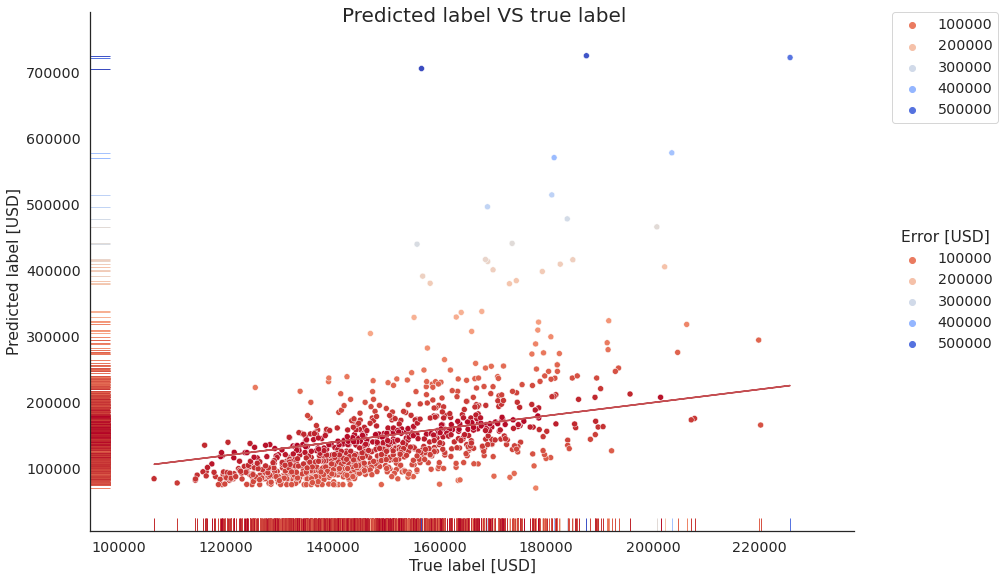

In [12]:
real_vs_pred(parsed_test_data, 1000)